In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

In [2]:
#load data
with open("/home/vrlab/Documents/HS/Hearthstone_Winrate/dataset/hsreply_data/decks.json", 'r') as f:
    decks_ori = json.load(f)

winrate = []
decks = []
cards = set()

for deck in decks_ori:
    tmp = []
    for card in deck['deck_list']:
        for i in range(card[1]):
            tmp.append(card[0])
    if len(tmp) == 30:
        decks.append(tmp)
        for card in tmp:
            cards.add(card)
        winrate.append(deck['win_rate']/100)

cards = list(cards)

print('cards num:', len(cards))
print('decks num:', len(decks))
print('deck example:', decks[0])
print(winrate[0])

cards num: 958
decks num: 736
deck example: [99957, 99957, 97467, 97467, 100595, 100595, 97406, 97683, 98283, 98283, 98285, 98762, 98762, 97282, 97282, 85154, 85154, 79780, 97528, 97528, 98768, 98768, 86626, 80647, 80647, 101375, 97269, 97269, 97394, 97394]
0.7648


In [3]:
# one hot encode
mapping = np.eye(len(cards))
print(cards)
cards = {cards[i]:mapping[i] for i in range(len(cards))}

decks = [[cards[card] for card in deck] for deck in decks]

decks = np.array(decks)
print(decks.shape)

[69632, 69635, 69636, 69637, 100358, 69638, 71688, 100361, 100362, 100363, 71690, 100365, 71694, 100367, 69643, 100369, 69649, 94225, 69654, 69655, 98328, 71705, 69658, 69660, 69663, 71712, 69665, 84003, 69668, 69667, 84007, 98344, 81961, 94248, 81963, 94251, 69674, 73774, 69683, 81972, 81973, 69684, 69688, 69689, 69691, 79932, 96077, 92222, 92225, 69698, 69700, 92228, 69702, 69703, 92232, 69705, 69706, 92235, 69707, 98377, 98382, 92237, 86092, 69713, 92240, 69718, 69721, 92250, 92249, 75866, 75868, 86109, 86111, 92256, 86112, 69625, 98403, 69731, 71781, 69734, 69735, 86120, 75881, 92266, 98411, 69740, 92268, 69742, 92267, 98417, 98123, 69629, 86132, 69630, 98427, 98434, 86150, 80014, 82067, 80021, 96909, 82072, 82073, 84292, 71841, 84132, 98469, 96422, 92325, 82088, 69640, 92332, 94381, 86190, 92335, 69641, 73906, 92338, 92340, 100537, 100539, 100540, 86209, 100546, 82116, 100553, 102212, 80083, 80085, 98520, 80089, 80090, 86235, 80091, 73721, 102214, 102215, 71917, 102218, 84206, 719

In [17]:
# Dataloader
inputs = torch.tensor(decks, dtype=torch.float).to('cuda')
gts = torch.tensor(winrate, dtype=torch.float).to('cuda')

X_train, X_test, y_train, y_test = train_test_split(inputs, gts, test_size=0.1, random_state=20)  

train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [5]:
from net import Transformer

In [6]:
input_size = len(cards)
hidden_size = 1024
output_size = 1
model = Transformer(input_size, input_size, input_size, 512).to('cuda:0')

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

In [7]:
num_epochs = 1000
losses = []
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    # 前向传播
    for input, gt in train_loader:
        # 前向传播
        outputs = model(input)
        loss = criterion(outputs, gt.view(-1, 1))

        # 反向传播和优化
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
        optimizer.zero_grad()
        # scheduler.step()
        running_loss += loss.item()
    
    losses.append(running_loss)

    plt.show()
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.5f}')
        with torch.no_grad():
            idxs = random.choices(range(len(inputs)), k=2)
            test_outputs = model(inputs[idxs])
            for i in range(2):
                print(f'pred: {test_outputs[i]}, gt: {gts[idxs[i]]}')


torch.save(model.state_dict(), 'model_weights.pth')

  5%|▌         | 50/1000 [00:21<06:56,  2.28it/s]

Epoch [50/1000], Loss: 0.66047
pred: tensor([0.5452], device='cuda:0'), gt: 0.531000018119812
pred: tensor([0.5923], device='cuda:0'), gt: 0.6470000147819519


 10%|█         | 100/1000 [00:43<06:28,  2.32it/s]

Epoch [100/1000], Loss: 0.49477
pred: tensor([0.6155], device='cuda:0'), gt: 0.64410001039505
pred: tensor([0.6082], device='cuda:0'), gt: 0.6322000026702881


 15%|█▌        | 150/1000 [01:04<06:06,  2.32it/s]

Epoch [150/1000], Loss: 0.39569
pred: tensor([0.5125], device='cuda:0'), gt: 0.5357000231742859
pred: tensor([0.6158], device='cuda:0'), gt: 0.6003999710083008


 20%|██        | 200/1000 [01:20<03:53,  3.43it/s]

Epoch [200/1000], Loss: 0.32365
pred: tensor([0.6495], device='cuda:0'), gt: 0.6941999793052673
pred: tensor([0.5979], device='cuda:0'), gt: 0.5443000197410583


 25%|██▌       | 250/1000 [01:40<05:23,  2.32it/s]

Epoch [250/1000], Loss: 0.26134
pred: tensor([0.4823], device='cuda:0'), gt: 0.5357000231742859
pred: tensor([0.5466], device='cuda:0'), gt: 0.5210999846458435


 30%|███       | 300/1000 [02:01<05:01,  2.32it/s]

Epoch [300/1000], Loss: 0.22497
pred: tensor([0.5581], device='cuda:0'), gt: 0.538100004196167
pred: tensor([0.5598], device='cuda:0'), gt: 0.6337000131607056


 35%|███▌      | 350/1000 [02:23<04:40,  2.32it/s]

Epoch [350/1000], Loss: 0.18934
pred: tensor([0.6110], device='cuda:0'), gt: 0.6191999912261963
pred: tensor([0.5945], device='cuda:0'), gt: 0.6729000210762024


 40%|████      | 400/1000 [02:44<04:18,  2.32it/s]

Epoch [400/1000], Loss: 0.16148
pred: tensor([0.5954], device='cuda:0'), gt: 0.49549999833106995
pred: tensor([0.5754], device='cuda:0'), gt: 0.5615000128746033


 45%|████▌     | 450/1000 [03:06<03:57,  2.32it/s]

Epoch [450/1000], Loss: 0.14322
pred: tensor([0.6860], device='cuda:0'), gt: 0.7070000171661377
pred: tensor([0.5907], device='cuda:0'), gt: 0.6035000085830688


 50%|█████     | 500/1000 [03:26<02:28,  3.37it/s]

Epoch [500/1000], Loss: 0.12328
pred: tensor([0.6869], device='cuda:0'), gt: 0.7307999730110168
pred: tensor([0.6423], device='cuda:0'), gt: 0.6317999958992004


 55%|█████▌    | 550/1000 [03:46<03:14,  2.32it/s]

Epoch [550/1000], Loss: 0.11152
pred: tensor([0.6227], device='cuda:0'), gt: 0.6237999796867371
pred: tensor([0.5719], device='cuda:0'), gt: 0.5932999849319458


 60%|██████    | 600/1000 [04:03<02:51,  2.33it/s]

Epoch [600/1000], Loss: 0.09763
pred: tensor([0.5525], device='cuda:0'), gt: 0.5514000058174133
pred: tensor([0.5999], device='cuda:0'), gt: 0.5971999764442444


 65%|██████▌   | 650/1000 [04:25<02:30,  2.32it/s]

Epoch [650/1000], Loss: 0.08824
pred: tensor([0.5335], device='cuda:0'), gt: 0.536300003528595
pred: tensor([0.5884], device='cuda:0'), gt: 0.5584999918937683


 70%|███████   | 700/1000 [04:47<02:09,  2.32it/s]

Epoch [700/1000], Loss: 0.07882
pred: tensor([0.5896], device='cuda:0'), gt: 0.5942000150680542
pred: tensor([0.6532], device='cuda:0'), gt: 0.7031999826431274


 75%|███████▌  | 750/1000 [05:08<01:47,  2.32it/s]

Epoch [750/1000], Loss: 0.07157
pred: tensor([0.6939], device='cuda:0'), gt: 0.7134000062942505
pred: tensor([0.6538], device='cuda:0'), gt: 0.6585999727249146


 80%|████████  | 800/1000 [05:30<01:26,  2.32it/s]

Epoch [800/1000], Loss: 0.06670
pred: tensor([0.6610], device='cuda:0'), gt: 0.6607000231742859
pred: tensor([0.5768], device='cuda:0'), gt: 0.5720999836921692


 85%|████████▌ | 850/1000 [05:45<00:43,  3.43it/s]

Epoch [850/1000], Loss: 0.06185
pred: tensor([0.5489], device='cuda:0'), gt: 0.5435000061988831
pred: tensor([0.5293], device='cuda:0'), gt: 0.5318999886512756


 90%|█████████ | 900/1000 [06:03<00:43,  2.32it/s]

Epoch [900/1000], Loss: 0.05689
pred: tensor([0.6077], device='cuda:0'), gt: 0.6169999837875366
pred: tensor([0.6020], device='cuda:0'), gt: 0.593500018119812


 95%|█████████▌| 950/1000 [06:21<00:14,  3.43it/s]

Epoch [950/1000], Loss: 0.05360
pred: tensor([0.5961], device='cuda:0'), gt: 0.6108999848365784
pred: tensor([0.5609], device='cuda:0'), gt: 0.5616000294685364


100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]

Epoch [1000/1000], Loss: 0.04816
pred: tensor([0.6587], device='cuda:0'), gt: 0.676800012588501
pred: tensor([0.4772], device='cuda:0'), gt: 0.47929999232292175


In [18]:
with torch.no_grad():
    inputs = X_test
    test_outputs = model(inputs)
    print(test_outputs.shape)
    for i in range(len(test_outputs)):
        print(f"pred: {test_outputs[i]} gt: {y_test[i]}")

    mse = criterion(test_outputs, y_test)
    print(f'Mean Squared Error on Test Data: {mse.item():.4f}')

torch.Size([74, 1])
pred: tensor([0.5514], device='cuda:0') gt: 0.5400999784469604
pred: tensor([0.6937], device='cuda:0') gt: 0.7002999782562256
pred: tensor([0.5168], device='cuda:0') gt: 0.5257999897003174
pred: tensor([0.4254], device='cuda:0') gt: 0.4083000123500824
pred: tensor([0.6196], device='cuda:0') gt: 0.6144000291824341
pred: tensor([0.6244], device='cuda:0') gt: 0.6204000115394592
pred: tensor([0.6020], device='cuda:0') gt: 0.5952000021934509
pred: tensor([0.5919], device='cuda:0') gt: 0.5895000100135803
pred: tensor([0.6057], device='cuda:0') gt: 0.6078000068664551
pred: tensor([0.6126], device='cuda:0') gt: 0.5940999984741211
pred: tensor([0.5602], device='cuda:0') gt: 0.5613999962806702
pred: tensor([0.6171], device='cuda:0') gt: 0.6496000289916992
pred: tensor([0.6249], device='cuda:0') gt: 0.58160001039505
pred: tensor([0.6613], device='cuda:0') gt: 0.6546000242233276
pred: tensor([0.6560], device='cuda:0') gt: 0.6531000137329102
pred: tensor([0.5563], device='cuda:0

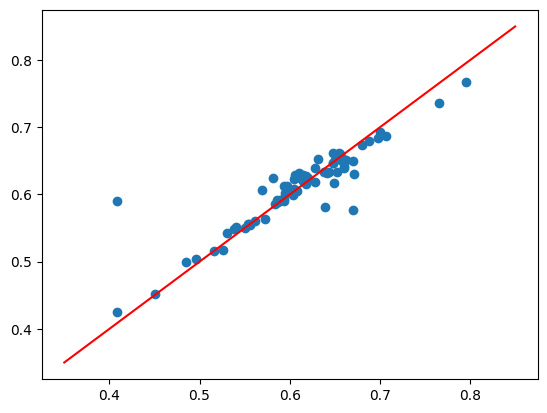

array([[1.        , 0.82222678],
       [0.82222678, 1.        ]])

In [19]:
plt.scatter(y_test.cpu(),test_outputs.cpu())
plt.plot(np.arange(0.35,.9,0.05),np.arange(0.35,.9,0.05), color='red')
plt.show()

np.corrcoef(y_test.cpu(),test_outputs.view(-1).cpu())**2

In [ ]:
avg_winrate = sum(winrate)/ len(winrate)
print(avg_winrate)

0.6013101902173915
